In [1]:
%matplotlib inline


# Joint PGI of Gravity + Magnetic on an Octree mesh without petrophysical information


This tutorial shows through a joint inversion of Gravity and Magnetic data on an
Octree mesh how to use the PGI framework introduced in Astic & Oldenburg (2019)
and Astic et al. (2021) to make geologic assumptions and learn a suitable
petrophysical distribution when no quantitative petrophysical information is
available.

Thibaut Astic, Douglas W. Oldenburg,
A framework for petrophysically and geologically guided geophysical inversion
using a dynamic Gaussian mixture model prior, Geophysical Journal International,
Volume 219, Issue 3, December 2019, Pages 1989–2012, DOI:
`10.1093/gji/ggz389 <https://doi.org/10.1093/gji/ggz389>`_.


Thibaut Astic, Lindsey J. Heagy, Douglas W Oldenburg,
Petrophysically and geologically guided multi-physics inversion using a dynamic
Gaussian mixture model, Geophysical Journal International,
Volume 224, Issue 1, January 2021, Pages 40-68, DOI: `10.1093/gji/ggaa378
<https://doi.org/10.1093/gji/ggaa378>`_.


## Import modules




In [2]:
from discretize import TreeMesh
from discretize.utils import active_from_xyz
import matplotlib.pyplot as plt
import numpy as np
import simpeg.potential_fields as pf
from simpeg import (
    data_misfit,
    directives,
    inverse_problem,
    inversion,
    maps,
    optimization,
    regularization,
    utils,
)
from simpeg.utils import io_utils

# Reproducible science
np.random.seed(518936)

## Setup




file already exists, new file is called /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/mesh_tutorial.ubc
   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/mesh_tutorial.ubc
Download completed!


file already exists, new file is called /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/geology_true.mod
   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/geology_true.mod
Download completed!


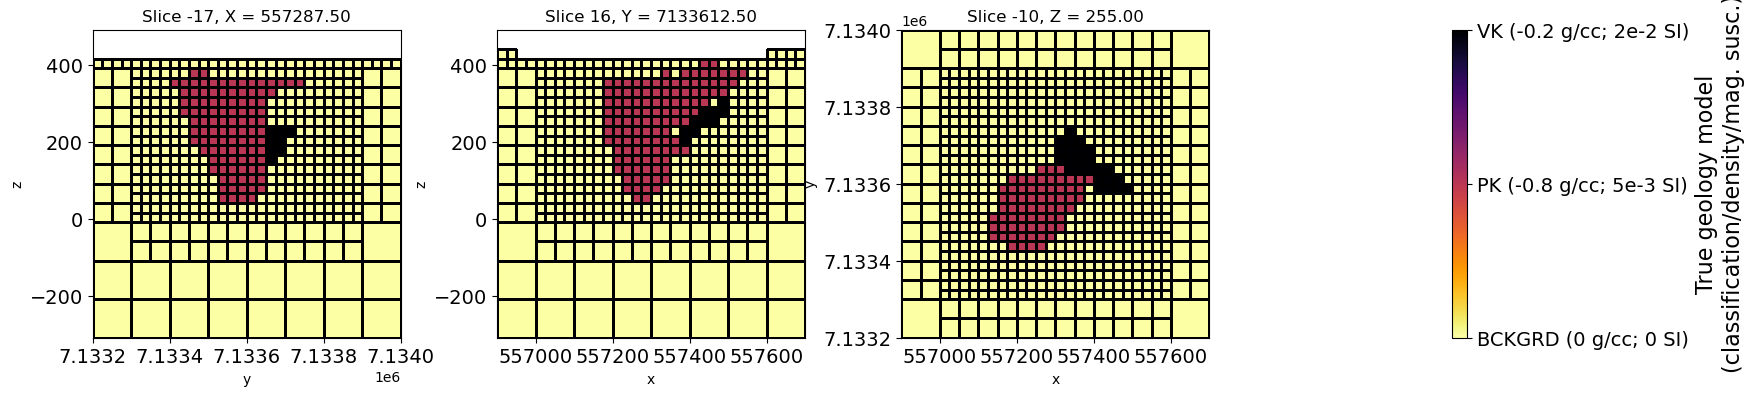

file already exists, new file is called /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/gravity_data.obs
   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/gravity_data.obs
Download completed!
file already exists, new file is called /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/magnetic_data.obs
   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/magnetic_data.obs
Download completed!


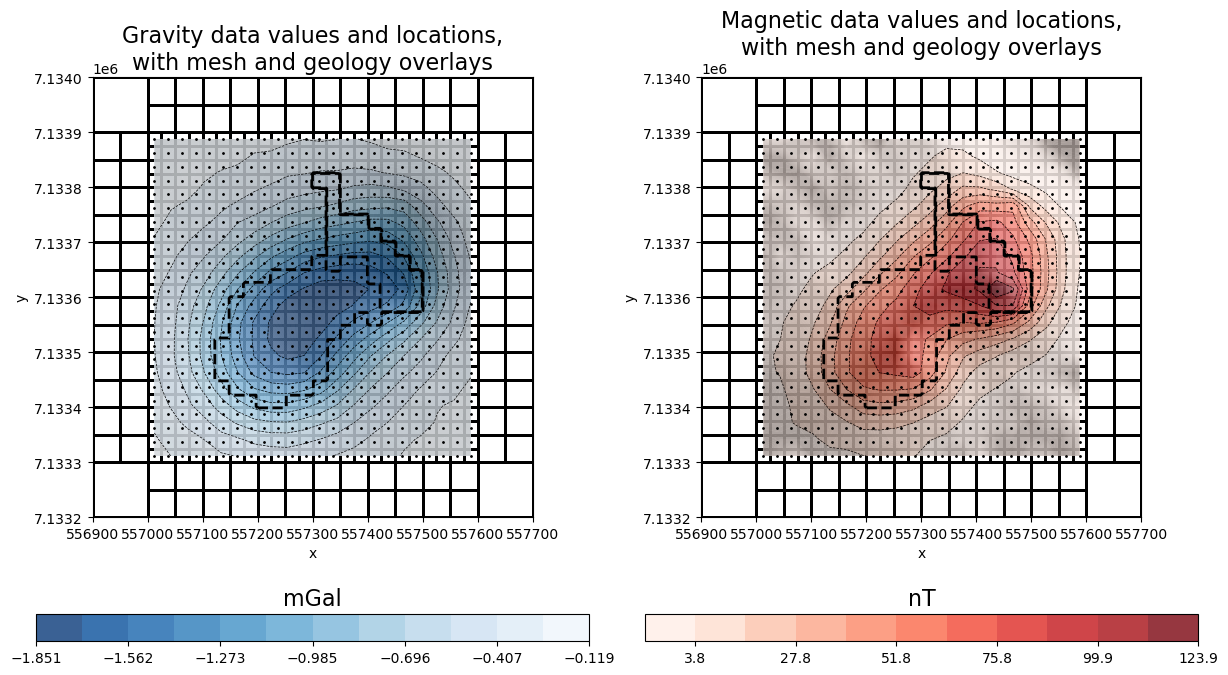

file already exists, new file is called /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/CDED_Lake_warp.xyz


   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/CDED_Lake_warp.xyz
Download completed!


In [3]:
# Load Mesh
mesh_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/mesh_tutorial.ubc"
)
mesh = TreeMesh.read_UBC(mesh_file)

# Load True geological model for comparison with inversion result
true_geology_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/geology_true.mod"
)
true_geology = mesh.read_model_UBC(true_geology_file)

# Plot true geology model
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ticksize, labelsize = 14, 16
for _, axx in enumerate(ax):
    axx.set_aspect(1)
    axx.tick_params(labelsize=ticksize)
mesh.plot_slice(
    true_geology,
    normal="X",
    ax=ax[0],
    ind=-17,
    clim=[0, 2],
    pcolor_opts={"cmap": "inferno_r"},
    grid=True,
)
mesh.plot_slice(
    true_geology,
    normal="Y",
    ax=ax[1],
    clim=[0, 2],
    pcolor_opts={"cmap": "inferno_r"},
    grid=True,
)
geoplot = mesh.plot_slice(
    true_geology,
    normal="Z",
    ax=ax[2],
    clim=[0, 2],
    ind=-10,
    pcolor_opts={"cmap": "inferno_r"},
    grid=True,
)
geocb = plt.colorbar(geoplot[0], cax=ax[3], ticks=[0, 1, 2])
geocb.set_label(
    "True geology model\n(classification/density/mag. susc.)", fontsize=labelsize
)
geocb.set_ticklabels(
    ["BCKGRD (0 g/cc; 0 SI)", "PK (-0.8 g/cc; 5e-3 SI)", "VK (-0.2 g/cc; 2e-2 SI)"]
)
geocb.ax.tick_params(labelsize=ticksize)
ax[3].set_aspect(10)
plt.show()

# Load geophysical data
data_grav_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/gravity_data.obs"
)
data_grav = io_utils.read_grav3d_ubc(data_grav_file)
data_mag_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/magnetic_data.obs"
)
data_mag = io_utils.read_mag3d_ubc(data_mag_file)

# plot data and mesh
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.reshape(-1)
plt.gca().set_aspect("equal")
plt.gca().set_xlim(
    [
        data_mag.survey.receiver_locations[:, 0].min(),
        data_mag.survey.receiver_locations[:, 0].max(),
    ],
)
plt.gca().set_ylim(
    [
        data_mag.survey.receiver_locations[:, 1].min(),
        data_mag.survey.receiver_locations[:, 1].max(),
    ]
)
mesh.plot_slice(
    np.ones(mesh.nC),
    normal="Z",
    ind=int(-10),
    grid=True,
    pcolor_opts={"cmap": "Greys"},
    ax=ax[0],
)
mm = utils.plot2Ddata(
    data_grav.survey.receiver_locations,
    -data_grav.dobs,
    ax=ax[0],
    level=True,
    nx=20,
    ny=20,
    dataloc=True,
    ncontour=12,
    shade=True,
    contourOpts={"cmap": "Blues_r", "alpha": 0.8},
    levelOpts={"colors": "k", "linewidths": 0.5, "linestyles": "dashed"},
)
ax[0].set_aspect(1)
ax[0].set_title(
    "Gravity data values and locations,\nwith mesh and geology overlays", fontsize=16
)
plt.colorbar(mm[0], cax=ax[2], orientation="horizontal")
ax[2].set_aspect(0.05)
ax[2].set_title("mGal", fontsize=16)
mesh.plot_slice(
    np.ones(mesh.nC),
    normal="Z",
    ind=int(-10),
    grid=True,
    pcolor_opts={"cmap": "Greys"},
    ax=ax[1],
)
mm = utils.plot2Ddata(
    data_mag.survey.receiver_locations,
    data_mag.dobs,
    ax=ax[1],
    level=True,
    nx=20,
    ny=20,
    dataloc=True,
    ncontour=11,
    shade=True,
    contourOpts={"cmap": "Reds", "alpha": 0.8},
    levelOpts={"colors": "k", "linewidths": 0.5, "linestyles": "dashed"},
)
ax[1].set_aspect(1)
ax[1].set_title(
    "Magnetic data values and locations,\nwith mesh and geology overlays", fontsize=16
)
plt.colorbar(mm[0], cax=ax[3], orientation="horizontal")
ax[3].set_aspect(0.05)
ax[3].set_title("nT", fontsize=16)
# overlay true geology model for comparison
indz = -9
indslicezplot = mesh.gridCC[:, 2] == mesh.cell_centers_z[indz]
for i in range(2):
    utils.plot2Ddata(
        mesh.gridCC[indslicezplot][:, [0, 1]],
        true_geology[indslicezplot],
        nx=200,
        ny=200,
        contourOpts={"alpha": 0},
        clim=[0, 2],
        ax=ax[i],
        level=True,
        ncontour=2,
        levelOpts={"colors": "k", "linewidths": 2, "linestyles": "--"},
        method="nearest",
    )
plt.subplots_adjust(hspace=-0.25, wspace=0.1)
plt.show()

# Load Topo
topo_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/CDED_Lake_warp.xyz"
)
topo = np.genfromtxt(topo_file, skip_header=1)
# find the active cells
actv = active_from_xyz(mesh, topo, "CC")
# Create active map to go from reduce set to full
ndv = np.nan
actvMap = maps.InjectActiveCells(mesh, actv, ndv)
nactv = int(actv.sum())

# Create simulations and data misfits
# Wires mapping
wires = maps.Wires(("den", actvMap.nP), ("sus", actvMap.nP))
gravmap = actvMap * wires.den
magmap = actvMap * wires.sus
idenMap = maps.IdentityMap(nP=nactv)
# Grav problem
simulation_grav = pf.gravity.simulation.Simulation3DIntegral(
    survey=data_grav.survey,
    mesh=mesh,
    rhoMap=wires.den,
    ind_active=actv,
)
dmis_grav = data_misfit.L2DataMisfit(data=data_grav, simulation=simulation_grav)
# Mag problem
simulation_mag = pf.magnetics.simulation.Simulation3DIntegral(
    survey=data_mag.survey,
    mesh=mesh,
    chiMap=wires.sus,
    ind_active=actv,
)
dmis_mag = data_misfit.L2DataMisfit(data=data_mag, simulation=simulation_mag)

Create a joint Data Misfit




In [4]:
# Joint data misfit
dmis = 0.5 * dmis_grav + 0.5 * dmis_mag

# initial model
m0 = np.r_[-1e-4 * np.ones(actvMap.nP), 1e-4 * np.ones(actvMap.nP)]

## Inversion with no petrophysical information about the means

In this scenario, we do not know the true petrophysical signature of each rock
unit. We thus make geologic assumptions to design a coupling term and perform
a multi-physics inversion. in addition to a neutral background, we assume that
one rock unit is only less dense, and the third one is only magnetic. As we
do not know their mean petrophysical values. We start with an initial guess
(-1 g/cc) for the updatable mean density-contrast value of the less dense unit
(with a fixed susceptibility of 0 SI). The magnetic-contrasting unit's updatable
susceptibility is initialized at a value of 0.1 SI (with a fixed 0 g/cc density
contrast). We then let the algorithm learn a suitable set of means under the set
constrained (fixed or updatable value), through the kappa argument, denoting our
confidences in each initial mean value (high confidence: fixed value; low
confidence: updatable value).




## Create a petrophysical GMM initial guess

The GMM is our representation of the petrophysical and geological information.
Here, we focus on the petrophysical aspect, with the means and covariances of
the physical properties of each rock unit.
To generate the data above, the PK unit was populated with a density contrast
of -0.8 g/cc and a magnetic susceptibility of 0.005 SI. The properties of the
HK unit were set at -0.2 g/cc and 0.02 SI. But here, we assume we
do not have this information. Thus, we start with initial guess for the means
and confidences kappa such that one unit is only less dense and one unit is only
magnetic, both embedded in a neutral background. The covariances matrices are set
so that we assume petrophysical noise levels of around 0.05 g/cc and 0.001 SI
for both unit. The background unit is set at a fixed null contrasts (0 g/cc
0 SI) with a petrophysical noise level of half of the above.




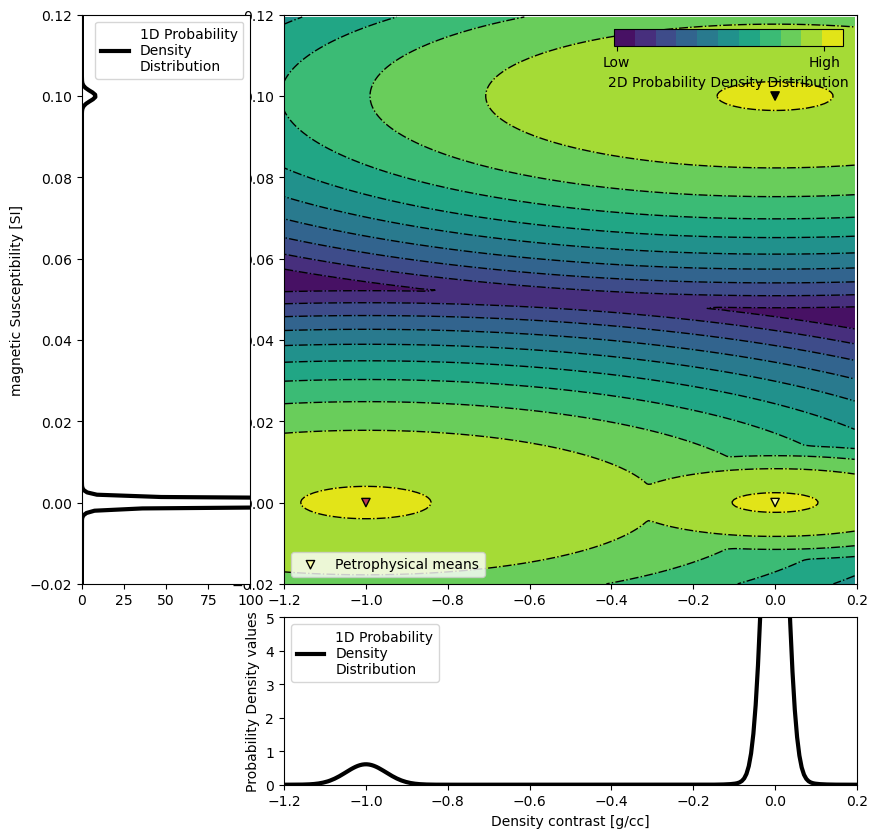

In [5]:
gmmref = utils.WeightedGaussianMixture(
    n_components=3,  # number of rock units: bckgrd, PK, HK
    mesh=mesh,  # inversion mesh
    actv=actv,  # actv cells
    covariance_type="diag",  # diagonal covariances
)
# required: initialization with fit
# fake random samples, size of the mesh
# number of physical properties: 2 (density and mag.susc)
gmmref.fit(np.random.randn(nactv, 2))
# set parameters manually
# set phys. prop means for each unit
gmmref.means_ = np.c_[
    [0.0, 0.0],  # BCKGRD density contrast and mag. susc
    [-1, 0.0],  # PK
    [0, 0.1],  # HK
].T
# set phys. prop covariances for each unit
gmmref.covariances_ = np.array(
    [[6e-04, 3.175e-07], [2.4e-03, 1.5e-06], [2.4e-03, 1.5e-06]]
)
# important after setting cov. manually: compute precision matrices and cholesky
gmmref.compute_clusters_precisions()
# set global proportions; low-impact as long as not 0 or 1 (total=1)
gmmref.weights_ = np.r_[0.9, 0.075, 0.025]

# Plot the 2D GMM
ax = gmmref.plot_pdf(flag2d=True, plotting_precision=250)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[2].set_xlim([0, 100])
plt.show()

## Inverse problem with no mean information





                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


Alpha scales: [9215418.186342454, 0.0, 6212966.8564262735, 0.0, 12323780.70080113, 0.0, 917439580.7251327, 0.0, 739047261.6876792, 0.0, 1690980576.2840345, 0.0]


<class 'simpeg.regularization.pgi.PGIsmallness'>
Initial data misfit scales:  [0.98271129 0.01728871]


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  1.77e-08  4.28e+06  9.99e+04  4.28e+06    2.17e+02      0              


geophys. misfits: 406453.4 (target 576.0 [False]); 125944.3 (target 576.0 [False]) | smallness misfit: 129199.8 (target: 11719.0 [False])
Beta cooling evaluation: progress: [406453.4 125944.3]; minimum progress targets: [3470231.3  572697.8]


mref changed in  4748  places


   1  1.77e-08  4.02e+05  2.17e+09  4.02e+05    2.04e+01      0              


geophys. misfits: 174016.6 (target 576.0 [False]); 60993.0 (target 576.0 [False]) | smallness misfit: 115388.3 (target: 11719.0 [False])
Beta cooling evaluation: progress: [174016.6  60993. ]; minimum progress targets: [325162.7 100755.4]


mref changed in  2588  places


   2  1.77e-08  1.72e+05  4.85e+09  1.72e+05    2.04e+01      0              


geophys. misfits: 72680.7 (target 576.0 [False]); 11238.2 (target 576.0 [False]) | smallness misfit: 91771.6 (target: 11719.0 [False])
Beta cooling evaluation: progress: [72680.7 11238.2]; minimum progress targets: [139213.3  48794.4]


mref changed in  1040  places


   3  1.77e-08  7.16e+04  5.03e+09  7.17e+04    1.97e+01      0   Skip BFGS  


geophys. misfits: 3817.3 (target 576.0 [False]); 488.7 (target 576.0 [True]) | smallness misfit: 70910.5 (target: 11719.0 [False])
Updating scaling for data misfits by  1.178589986004079
New scales: [0.98529249 0.01470751]
Beta cooling evaluation: progress: [3817.3  488.7]; minimum progress targets: [58144.5  8990.6]


mref changed in  561  places


   4  1.77e-08  3.77e+03  5.24e+09  3.86e+03    1.83e+01      0   Skip BFGS  


geophys. misfits: 182.4 (target 576.0 [True]); 92.9 (target 576.0 [True]) | smallness misfit: 64547.0 (target: 11719.0 [False])
Beta cooling evaluation: progress: [182.4  92.9]; minimum progress targets: [3053.8  691.2]
Warming alpha_pgi to favor clustering:  4.678667384649553


mref changed in  170  places


   5  1.77e-08  1.81e+02  5.58e+09  2.80e+02    2.57e+01      0   Skip BFGS  


geophys. misfits: 180.2 (target 576.0 [True]); 48.0 (target 576.0 [True]) | smallness misfit: 60607.6 (target: 11719.0 [False])
Beta cooling evaluation: progress: [180.2  48. ]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  35.550935389775304


mref changed in  11  places


   6  1.77e-08  1.78e+02  7.65e+09  3.14e+02    3.80e+01      0   Skip BFGS  


geophys. misfits: 148.9 (target 576.0 [True]); 704.4 (target 576.0 [False]) | smallness misfit: 49232.4 (target: 11719.0 [False])
Updating scaling for data misfits by  3.8671979238618825
New scales: [0.94542456 0.05457544]
Beta cooling evaluation: progress: [148.9 704.4]; minimum progress targets: [691.2 691.2]
Decreasing beta to counter data misfit increase.


mref changed in  39  places


   7  8.84e-09  1.79e+02  7.70e+09  2.47e+02    1.88e+01      0              


geophys. misfits: 153.4 (target 576.0 [True]); 620.1 (target 576.0 [False]) | smallness misfit: 48942.6 (target: 11719.0 [False])
Updating scaling for data misfits by  3.7541556200164496
New scales: [0.82188729 0.17811271]
Beta cooling evaluation: progress: [153.4 620.1]; minimum progress targets: [691.2 691.2]


mref changed in  5  places


   8  8.84e-09  2.37e+02  7.68e+09  3.04e+02    1.78e+01      4   Skip BFGS  


geophys. misfits: 134.8 (target 576.0 [True]); 175.2 (target 576.0 [True]) | smallness misfit: 49630.7 (target: 11719.0 [False])
Beta cooling evaluation: progress: [134.8 175.2]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  134.39856649161507


mref changed in  127  places


   9  8.84e-09  1.42e+02  1.48e+10  2.72e+02    1.67e+01      0              


geophys. misfits: 99.9 (target 576.0 [True]); 104.5 (target 576.0 [True]) | smallness misfit: 34321.9 (target: 11719.0 [False])
Beta cooling evaluation: progress: [ 99.9 104.5]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  757.7379331706601


mref changed in  7  places


  10  8.84e-09  1.01e+02  3.95e+10  4.50e+02    3.20e+01      0              


geophys. misfits: 137.6 (target 576.0 [True]); 232.7 (target 576.0 [True]) | smallness misfit: 17980.2 (target: 11719.0 [False])
Beta cooling evaluation: progress: [137.6 232.7]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  2523.4772056772103


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


  11  8.84e-09  1.55e+02  7.31e+10  8.01e+02    3.24e+01      0              


geophys. misfits: 156.7 (target 576.0 [True]); 325.8 (target 576.0 [True]) | smallness misfit: 15825.0 (target: 11719.0 [False])
Beta cooling evaluation: progress: [156.7 325.8]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  6867.9684043512425


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


  12  8.84e-09  1.87e+02  1.63e+11  1.63e+03    3.36e+01      2              


geophys. misfits: 454.8 (target 576.0 [True]); 380.7 (target 576.0 [True]) | smallness misfit: 10044.4 (target: 11719.0 [True])
All targets have been reached
Beta cooling evaluation: progress: [454.8 380.7]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  9545.70119405911


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.2752e+05
0 : |xc-x_last| = 1.5440e+00 <= tolX*(1+|x0|) = 1.0153e-01
0 : |proj(x-g)-x|    = 3.2774e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.2774e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =     13
------------------------- DONE! -------------------------


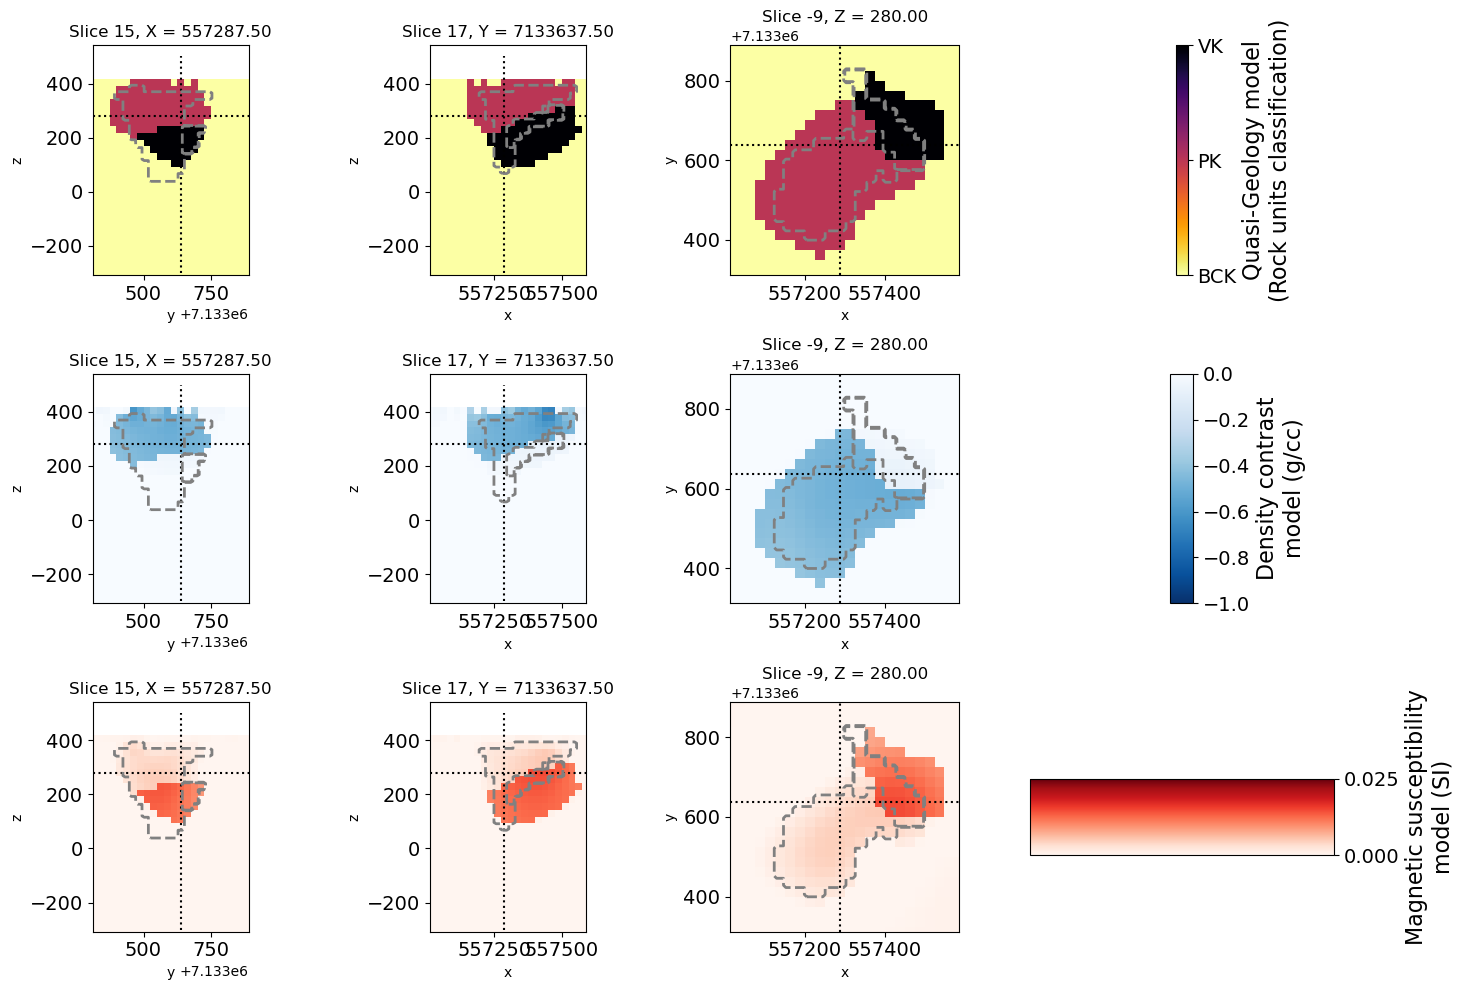

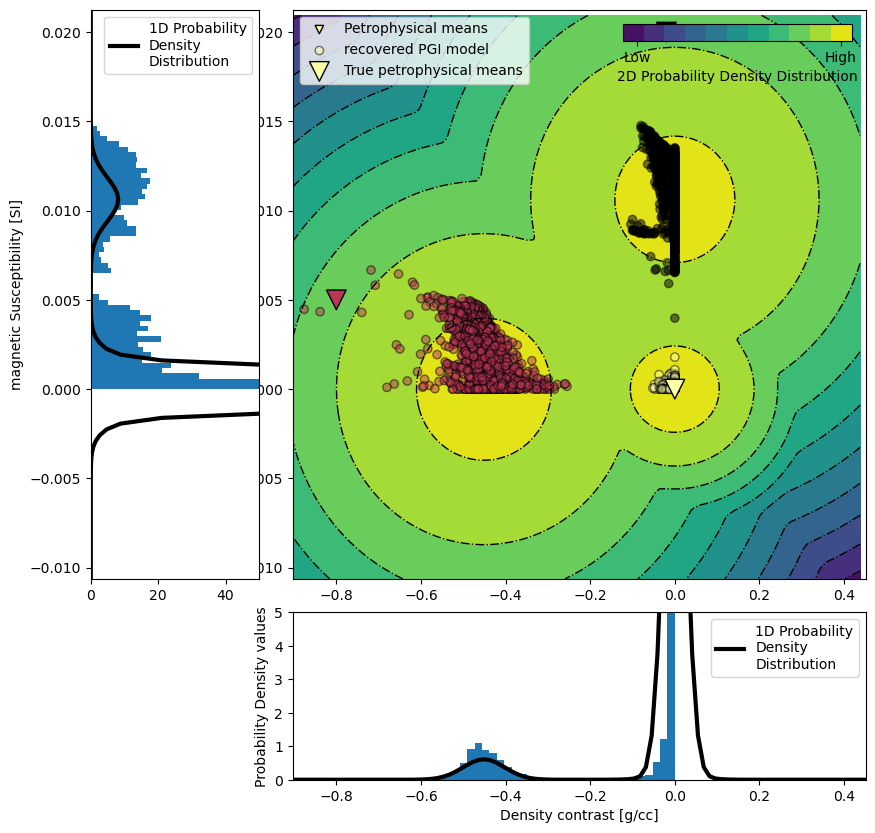

In [6]:
# Create PGI regularization
# Sensitivity weighting
wr_grav = np.sum(simulation_grav.G**2.0, axis=0) ** 0.5 / (mesh.cell_volumes[actv])
wr_grav = wr_grav / np.max(wr_grav)

wr_mag = np.sum(simulation_mag.G**2.0, axis=0) ** 0.5 / (mesh.cell_volumes[actv])
wr_mag = wr_mag / np.max(wr_mag)

# create joint PGI regularization with smoothness
reg = regularization.PGI(
    gmmref=gmmref,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap, idenMap],
    active_cells=actv,
    alpha_pgi=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
    # use the classification of the initial model (here, all background unit)
    # as initial reference model
    reference_model=utils.mkvc(
        gmmref.means_[gmmref.predict(m0.reshape(actvMap.nP, -1))]
    ),
    weights_list=[wr_grav, wr_mag],  # weights each phys. prop. by correct sensW
)

# Directives
# Add directives to the inversion
# ratio to use for each phys prop. smoothness in each direction:
# roughly the ratio of range of each phys. prop.
alpha0_ratio = np.r_[
    1e-2 * np.ones(len(reg.objfcts[1].objfcts[1:])),
    1e-2 * 100.0 * np.ones(len(reg.objfcts[2].objfcts[1:])),
]
Alphas = directives.AlphasSmoothEstimate_ByEig(alpha0_ratio=alpha0_ratio, verbose=True)
# initialize beta and beta/alpha_s schedule
beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-4)
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True,
    coolingFactor=2.0,
    tolerance=0.2,
    progress=0.2,
)
# geophy. and petro. target misfits
targets = directives.MultiTargetMisfits(
    verbose=True,
    chiSmall=0.5,  # ask for twice as much clustering (target value is /2)
)
# add learned mref in smooth once stable
MrefInSmooth = directives.PGI_AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
)
# update the parameters in smallness (L2-approx of PGI)
update_smallness = directives.PGI_UpdateParameters(
    update_gmm=True,  # update the GMM each iteration
    kappa=np.c_[  # confidences in each mean phys. prop. of each cluster
        1e10
        * np.ones(
            2
        ),  # fixed background at 0 density, 0 mag. susc. (high confidences of 1e10)
        [
            0,
            1e10,
        ],  # density-contrasting cluster: updatable density mean, fixed mag. susc.
        [
            1e10,
            0,
        ],  # magnetic-contrasting cluster: fixed density mean, updatable mag. susc.
    ].T,
)
# pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()
# iteratively balance the scaling of the data misfits
scaling_init = directives.ScalingMultipleDataMisfits_ByEig(chi0_ratio=[1.0, 100.0])
scale_schedule = directives.JointScalingSchedule(verbose=True)

# Create inverse problem
# Optimization
# set lower and upper bounds
lowerbound = np.r_[-2.0 * np.ones(actvMap.nP), 0.0 * np.ones(actvMap.nP)]
upperbound = np.r_[0.0 * np.ones(actvMap.nP), 1e-1 * np.ones(actvMap.nP)]
opt = optimization.ProjectedGNCG(
    maxIter=30,
    lower=lowerbound,
    upper=upperbound,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-4,
)
# create inverse problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
inv = inversion.BaseInversion(
    invProb,
    # directives: evaluate alphas (and data misfits scales) before beta
    directiveList=[
        Alphas,
        scaling_init,
        beta,
        update_smallness,
        targets,
        scale_schedule,
        betaIt,
        MrefInSmooth,
        update_Jacobi,
    ],
)
# Invert
pgi_model_no_info = inv.run(m0)


# Plot the result with full petrophysical information
density_model_no_info = gravmap * pgi_model_no_info
magsus_model_no_info = magmap * pgi_model_no_info
learned_gmm = reg.objfcts[0].gmm
quasi_geology_model_no_info = actvMap * reg.objfcts[0].compute_quasi_geology_model()

fig, ax = plt.subplots(3, 4, figsize=(15, 10))
for _, axx in enumerate(ax):
    for _, axxx in enumerate(axx):
        axxx.set_aspect(1)
        axxx.tick_params(labelsize=ticksize)

indx = 15
indy = 17
indz = -9
# geology model
mesh.plot_slice(
    quasi_geology_model_no_info,
    normal="X",
    ax=ax[0, 0],
    clim=[0, 2],
    ind=indx,
    pcolor_opts={"cmap": "inferno_r"},
)
mesh.plot_slice(
    quasi_geology_model_no_info,
    normal="Y",
    ax=ax[0, 1],
    clim=[0, 2],
    ind=indy,
    pcolor_opts={"cmap": "inferno_r"},
)
geoplot = mesh.plot_slice(
    quasi_geology_model_no_info,
    normal="Z",
    ax=ax[0, 2],
    clim=[0, 2],
    ind=indz,
    pcolor_opts={"cmap": "inferno_r"},
)
geocb = plt.colorbar(geoplot[0], cax=ax[0, 3], ticks=[0, 1, 2])
geocb.set_ticklabels(["BCK", "PK", "VK"])
geocb.set_label("Quasi-Geology model\n(Rock units classification)", fontsize=16)
ax[0, 3].set_aspect(10)

# gravity model
mesh.plot_slice(
    density_model_no_info,
    normal="X",
    ax=ax[1, 0],
    clim=[-1, 0],
    ind=indx,
    pcolor_opts={"cmap": "Blues_r"},
)
mesh.plot_slice(
    density_model_no_info,
    normal="Y",
    ax=ax[1, 1],
    clim=[-1, 0],
    ind=indy,
    pcolor_opts={"cmap": "Blues_r"},
)
denplot = mesh.plot_slice(
    density_model_no_info,
    normal="Z",
    ax=ax[1, 2],
    clim=[-1, 0],
    ind=indz,
    pcolor_opts={"cmap": "Blues_r"},
)
dencb = plt.colorbar(denplot[0], cax=ax[1, 3])
dencb.set_label("Density contrast\nmodel (g/cc)", fontsize=16)
ax[1, 3].set_aspect(10)

# magnetic model
mesh.plot_slice(
    magsus_model_no_info,
    normal="X",
    ax=ax[2, 0],
    clim=[0, 0.025],
    ind=indx,
    pcolor_opts={"cmap": "Reds"},
)
mesh.plot_slice(
    magsus_model_no_info,
    normal="Y",
    ax=ax[2, 1],
    clim=[0, 0.025],
    ind=indy,
    pcolor_opts={"cmap": "Reds"},
)
susplot = mesh.plot_slice(
    magsus_model_no_info,
    normal="Z",
    ax=ax[2, 2],
    clim=[0, 0.025],
    ind=indz,
    pcolor_opts={"cmap": "Reds"},
)
suscb = plt.colorbar(susplot[0], cax=ax[2, 3])
suscb.set_label("Magnetic susceptibility\nmodel (SI)", fontsize=16)
ax[2, 3].set_aspect(10)

# overlay true geology model for comparison
indslicexplot = mesh.gridCC[:, 0] == mesh.cell_centers_x[indx]
indsliceyplot = mesh.gridCC[:, 1] == mesh.cell_centers_y[indy]
indslicezplot = mesh.gridCC[:, 2] == mesh.cell_centers_z[indz]
for i in range(3):
    for j, (plane, indd) in enumerate(
        zip([[1, 2], [0, 2], [0, 1]], [indslicexplot, indsliceyplot, indslicezplot])
    ):
        utils.plot2Ddata(
            mesh.gridCC[indd][:, plane],
            true_geology[indd],
            nx=100,
            ny=100,
            contourOpts={"alpha": 0},
            clim=[0, 2],
            ax=ax[i, j],
            level=True,
            ncontour=2,
            levelOpts={"colors": "grey", "linewidths": 2, "linestyles": "--"},
            method="nearest",
        )

# plot the locations of the cross-sections
for i in range(3):
    ax[i, 0].plot(
        mesh.cell_centers_y[indy] * np.ones(2), [-300, 500], c="k", linestyle="dotted"
    )
    ax[i, 0].plot(
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
        mesh.cell_centers_z[indz] * np.ones(2),
        c="k",
        linestyle="dotted",
    )
    ax[i, 0].set_xlim(
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
    )

    ax[i, 1].plot(
        mesh.cell_centers_x[indx] * np.ones(2), [-300, 500], c="k", linestyle="dotted"
    )
    ax[i, 1].plot(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
        mesh.cell_centers_z[indz] * np.ones(2),
        c="k",
        linestyle="dotted",
    )
    ax[i, 1].set_xlim(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
    )

    ax[i, 2].plot(
        mesh.cell_centers_x[indx] * np.ones(2),
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
        c="k",
        linestyle="dotted",
    )
    ax[i, 2].plot(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
        mesh.cell_centers_y[indy] * np.ones(2),
        c="k",
        linestyle="dotted",
    )
    ax[i, 2].set_xlim(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
    )
    ax[i, 2].set_ylim(
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
    )

plt.tight_layout()
plt.show()

# Plot the learned 2D GMM
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((4, 4), (3, 1), colspan=3)
ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3)
ax = [ax0, ax1, ax2]
learned_gmm.plot_pdf(flag2d=True, ax=ax, padding=1, plotting_precision=100)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_xlim([0, 50])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[1].scatter(
    density_model_no_info[actv],
    magsus_model_no_info[actv],
    c=quasi_geology_model_no_info[actv],
    cmap="inferno_r",
    edgecolors="k",
    label="recovered PGI model",
    alpha=0.5,
)
ax[0].hist(density_model_no_info[actv], density=True, bins=50)
ax[2].hist(magsus_model_no_info[actv], density=True, bins=50, orientation="horizontal")
ax[1].scatter(
    [0, -0.8, -0.02],
    [0, 0.005, 0.02],
    label="True petrophysical means",
    cmap="inferno_r",
    c=[0, 1, 2],
    marker="v",
    edgecolors="k",
    s=200,
)
ax[1].legend()
plt.show()